In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math 
import warnings
from scipy.io.wavfile import write
import discrete_signal
from scipy.io.wavfile import write
import sounddevice as sd


In [13]:

class dft():
    """
    dft Discrete Fourier transform.
    solve1,solve2,solve3 are the discrete Fourier transform (DFT) of
    vector x. There are three different ways of obtaining the DFT.
    The most efficient way of obtaining the dft is method 3, but 1
    and 2 are included for educational purposes.
    X is a vector that contains the DFT coefficients and f is a
    vector that contains the real frequencies determined by sampling
    frequency fs. f are the frequencies starting at f=0 and X are the
    corresponding frequency components. f_c is a vector containing the
    frequencies such that f_c=0 is at the center, and X_c contains the
    frequency components corresponding to f_c. In essence, f_c and X_c
    are the centered counterparts of f and X. Frequency 0 is always
    present.
    If a parameter K is given, solve1,solve2, solve3 computes the DFT with
    only K coefficients. Recall that this periodizes signal x with period K.
    If the length of the signal x is less than K, then the signal will be
    padded with zeros. If the length of the signal x is greater than K,
    then there will be aliasing occured from periodizing singal x with
    period K. f_c and X_c are the centered counterparts of f and X
    """
    def __init__(self, x, fs, K=None):
        """
        :param x: Input vector x contains the discrete signal
        :param fs: Input integer fs contains the sample frequency
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. If K is not provided, K=length(x).
        """
    # START: SANITY CHECK OF INPUTS.
        if (type(fs) != int) or (fs<=0):
            raise NameError('The frequency fs should be a positive integer.')
        if not isinstance(x, np. ndarray):
            raise NameError('The input signal x must be a numpy array.')
        if isinstance(x, np. ndarray):
            if x.ndim!=1:
                raise NameError('The input signal x must be a numpy vector array.')
        self.x=x
        self.fs=fs
        self.N=len(x)
        if K == None:
            K = len(self.x)
        # START: SANITY CHECK OF INPUTS.
        if (type(K) != int) or (K <= 0) or (K < 0):
            raise NameError('K should be a positive integer.')
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.
    def changeK(self,K):
        """
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. This function changes the attribute K of the class.
        """
        if (type(K) != int) or (K <= 0) or (K <  0):
            raise NameError('K should be a positive integer.')
        old_K=self.K
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.
        print('The value of K was succefully change from %d to %d'%(old_K,self.K))
        pass

    def solve1(self):
        """
        \\\\\ METHOD 1: For loops
        By definition of DFT (eq. 1, lab 2) we have that
        X(k) = 1/sqrt(N) * sum_{n=0 to N-1} x(n) exp(-j 2 pi k n / N)
        where n is the discrete time index, k is the discrete time frequency and N is
        the length of the time signal x. Observe that this gives the DFT coefficient
        for a single coefficient k. We are trying to look for all coefficients
        k=0,1,...,K.
        This means that, for each value of k=0,1,...,K we will need to compute N
        multiplications x(n)*exp(-j 2 pi k n / N), for n=0,1,...,N-1, and sum the
        result.
        First thing we need is to create the variable X that we will output. This will
        be a vector of length K.
        """

        X=np.zeros(self.K,dtype=np.complex_)
        for k in range (self.K) :# For each time index k=0,1,...,K;
            for n in range (self.N):  # For each frequency n=0,1,...,N-1:
                X[k]=X[k]+1/np.sqrt(self.N)*self.x[n]*np.exp(-1j*2*cmath.pi*k*n/self.K)

        # Obs: in the case we have K different from N, then the
   		# signal will be periodized with period K. That is why the
        # exponential is divided by K instead of N.
        X_c=np.roll(X,np.int(np.ceil(self.K/2)-1)) # Circularly shift X to get it centered in f_c==0
        return [self.f,X,self.f_c,X_c]

    def solve2(self):
        """
        \\\\ METHOD 2: Matrix form
        Using for loops in python is rather expensive. Numpy is already optimized to
        work with vectors and matrices, so it's a good idea to take advantage of this,
        together with the built-in elementwise operators.
        Observe that we want a vector X=[X(0) X(1) ... X(K-1)]'=[X(k), k=0,...,K-1]'
        and that each element of the vector is computed as before:
        X(k) = 1/sqrt(N) * sum_{n=0 to N-1} x(n) exp(-j 2 pi k n / N)
        But, as mentioned in (eq. 2, lab. 2) this is nothing more than the inner
        product of x=[x(0) ... x(N-1)]'=[x(n), n=0,...,N-1]' with the complex
        exponential of frequency K and length N ekN=[ekN(0) ... ekN(N-1)]'=[ekN(n),
        n=0,...,N-1]', so that X(0)=<x,e0N>=e0N'*x, X(1)=<x,e1N>=e1N*x', ...,
        X(K-1)=<x,e(K-1)N>=e(K-1)N'*x. So we see that we have a bunch of vectors
        {ekN, k=0,...,K-1} that always multiply the same vector x. We can achieve
        this by creating a matrix where each of the ekN is a row, and then get
        the full vector X by multiplying this matrix by x. We will denote the
        matrix as WKN for future reference:
        WKN=[e0N'; e1N'; ... ; e(K-1)N'];
        Finally, observe that as we move from row to row, k grows from 0 to K-1.
        And as we move from column to column, it is n that grows from 0 to N-1.
        Also, observe that ekN is a function of (k,n) given by exp(-j 2 pi k n /K).
        So if we create a matrices of indices (k,n) then we can directly apply
        the exponential by making use of the elementwise nature of this operation
        in Numpy.
        """
        matrix_k=np.transpose(np.tile(np.arange(self.K),(self.N,1)))
        matrix_n=np.tile(np.transpose(np.arange(self.N)),(self.K,1))
        indices=np.multiply(matrix_k,matrix_n)
        WKN=1/np.sqrt(self.N)*np.exp(-1j*2*np.pi*indices/self.K)
        X=WKN@self.x

        X_c=np.roll(X,np.int(np.ceil(self.K/2)-1)) # Circularly shift X to get it centered in f_c==0
        return [self.f,X,self.f_c,X_c]

    def solve3(self):
        """
        \\\\\ METHOD 3: Built-in fft() function
        Even though the matrix form is fast, it is still not fast enough for large
        signals x. For that, it is better to use the built in fft() function which is
        the optimal way to compute a dft. Besides, it is really easy to code.
        """
        X=np.fft.fft(self.x,self.K)/np.sqrt(self.N);
        # \\\\\ CENTER FFT.
        X_c=np.roll(X,np.int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
        return [self.f,X,self.f_c,X_c]


In [14]:
class idft():
    """
    idft Inverse Discrete Fourier transform.
    """

    def __init__(self, X, fs, N, K=None):
        """
        :param X: Input DFT X
        :param fs: Input integer fs contains the sample frequency
        :param N: The number of total signal samples N
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the iDFT.
        """
        self.X = X
        self.fs = fs
        self.N = N
        self.K = K
        if self.K == None:
            self.K = int(len(X) / 2) - 1

    def solve_K(self):
        """
        \\\\\ METHOD: Compute the iDFT with truncated K coefficients (Due to computation complexity, we will not use it in Section 2)
        :return iDFT x of duration N from partial DFT X, i.e., X[0], ..., X[K] with K < N/2
        :Treal the realt time vector of size N
        """
        x = np.zeros(self.N)

        for n in range(self.N):
            x[n] = 1 / np.sqrt(self.N) * self.X[0] * np.exp(1j * 2 * cmath.pi * 0 * n / self.N)
            for k in range(1, self.K + 1):
                x[n] = x[n] + 1 / np.sqrt(self.N) * self.X[k] * np.exp(1j * 2 * cmath.pi * k * n / self.N)
                x[n] = x[n] + 1 / np.sqrt(self.N) * np.conj(self.X[k]) * np.exp(-1j * 2 * cmath.pi * k * n / self.N)

        Ts = 1 / self.fs
        Treal = np.arange(self.N) * Ts

        return x, Treal

    def solve_ifft(self):
        """
        \\\\\ METHOD: Compute the iDFT with provided function np.fft.ifft (Computationally efficient)
        :Treal the realt time vector of size N
        """
        x = np.fft.ifft(self.X, self.N) * np.sqrt(self.N)

        Ts = 1 / self.fs
        Treal = np.arange(self.N) * Ts

        return x, Treal

In [11]:
class recordsound():
    """
    recordsound Record your voice for T time sampled at a frequency fs
    solve() generates a sampled signal of your voice and save it into a wav file
    """
    def __init__(self, T, fs):
        """
        :param T: the duration time
        :param fs: the sampling frequency
        """
        self.T = T
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        print('start recording')
        voicerecording = sd.rec(int(self.T * self.fs), self.fs, 1)
        sd.wait()  # Wait until recording is finished
        print('end recording')
        write('myvoice.wav', self.fs, voicerecording)  # Save as WAV file 
        
        return voicerecording

In [2]:
class gaussian():
    def __init__(self, mu, sigma, T, fs):
        
        self.N = np.int(np.floor( 2 *  T * fs))
        self.t = np.arange(-T, T, 1 / fs)
        self.sig = np.exp(-(self.t-mu)**2 / (2 * sigma**2))

        self.t = np.arange(-T, T, 1 / fs)

In [3]:
def gauss_ft(mu, sigma, f):
    
    gauss_ft = np.exp(- 2* (math.pi**2) *(f**2) *(sigma**2) + 1j * 2* math.pi * f * mu) * np.sqrt(2 * math.pi) * sigma 
        
    return gauss_ft  

In [ ]:
def q_11(sigma):
    

Modulation and demodulation

In [17]:
def bandlimit(x, fs, fmax):
      
    N = len(x)
    DFT = dft(x, fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    index_min = np.min( np.where(f_c >= -fmax)[0])
    index_max = np.max( np.where(f_c <= fmax)[0])

    X_band = np.concatenate(( np.zeros(index_min+1), X_c[index_min: index_max] ,  np.zeros( N - index_max-1)))

    X_band_n = np.roll( X_band, np.int(np.ceil( N / 2 )))
      
    iDFT = idft(X_band_n, fs, N)
    x_bandlim, Treal = iDFT.solve_ifft()
    
    return x_bandlim.real, Treal,  X_c, f_c, X_band

In [18]:
def q_21(x, x_bl, Treal, X_c, f_c, X_band):
    """
    Question 2.1_create bandlimited signal, plot the original and limited signal, 
    save the bandlimited voice signal    
    """
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('original signal and spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, X_c)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')

    plt.show() 
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('bandlimited spectrum and signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[1].plot(Treal, x_bl)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    axs[0].plot(f_c, X_band)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    plt.show() 
    
    write('bandlimited_myvoice.wav', fs, x_bl.astype(np.float32))

In [6]:

def q_22(x, g, fs):
    """
    Question 2.2_exponential modulation
    
    """
    N = len(x)
    n = np.arange(N)
    discrete_exponential = np.exp(2 * math.pi*1j* g * n / fs)
    x_mod = x * discrete_exponential
    
    return x_mod


In [19]:
def cos_modu(x, g, fs):
    """
    Question 2.3_cosine modulation
    
    """    
    N = len(x)
    n = np.arange(N)
    discrete_cosine = np.cos(2 * math.pi * g * n / fs)
    x_mod = x * discrete_cosine
    
    return x_mod
    
    
def q_23(x_band, x_mod, fs, Treal):
    """
    Question 2.3_cosine modulation, plot the signals in time and frequency domain
    
    """       
    
    DFT = dft(x_band, fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    DFT_mod = dft(x_mod, fs)
    [freqs, X, f_mod, X_mod] = DFT_mod.solve3()
    
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('original signal and modulated signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(Treal, x_band)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, x_mod)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('original signal and modulated signal spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(f_c, X_c)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_mod, X_mod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    


In [20]:
def q_25(z, g, fs, fmax):
    """
    Question 2.5_demodulation
    
    """      
    N= len(z)
    
    DFT = dft(z, fs)
    [freqs, X, f_Zc, Z_c] = DFT.solve3()
    
    y_demod_inter = cos_modu(z, g, fs)
    DFT = dft(y_demod_inter, fs)
    [freqs, Y, f_c, Y_demod_inter] = DFT.solve3()
    
    index_min = np.min( np.where(f_c >= -fmax)[0])
    index_max = np.max( np.where(f_c <= fmax)[0])
    Y_demod = np.concatenate(( np.zeros(index_min+1), Y_demod_inter[index_min: index_max]*2 ,  np.zeros( N - index_max-1)))
    Y_demod_n = np.roll( Y_demod, np.int(np.ceil( N / 2 )) )
    iDFT = idft(Y_demod_n, fs, N)
    y_demod, Treal = iDFT.solve_ifft()
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('demodulated signal spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(f_c, Y_demod_inter)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_c, Y_demod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('original signal and modulated signal spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(f_Zc, Z_c)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_c, Y_demod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('mixed signal and demodulated signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(Treal, z)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, y_demod.real)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    
    write('demodulated_myvoice'+str(g)+'.wav', fs, y_demod.real.astype(np.float32))
    
    return y_demod.real

    
    
    
    



start recording
end recording
start recording
end recording


/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/3926485043.py:144: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(X,np.int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/784668522.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` t

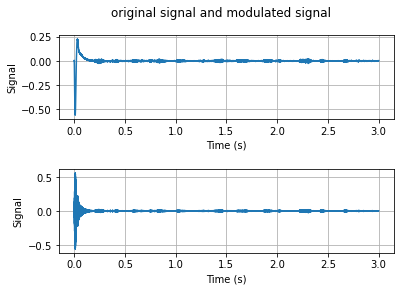

/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


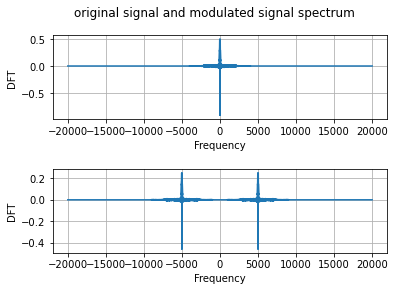

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/3926485043.py:144: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(X,np.int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/784668522.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` t

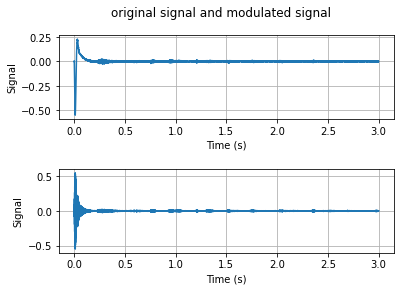

/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


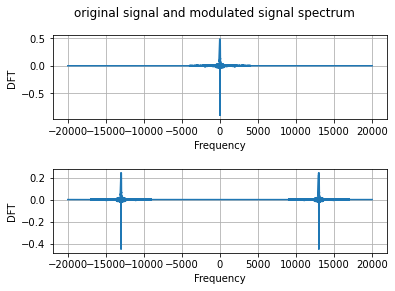

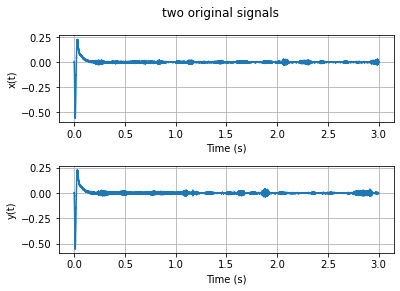

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/3926485043.py:144: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(X,np.int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/619868501.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` t

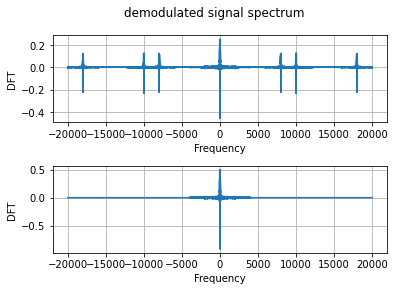

/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


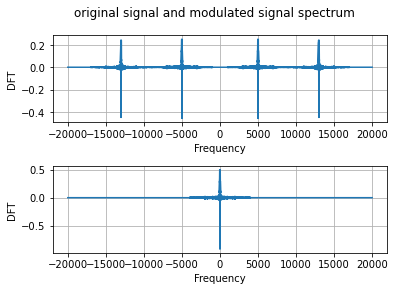

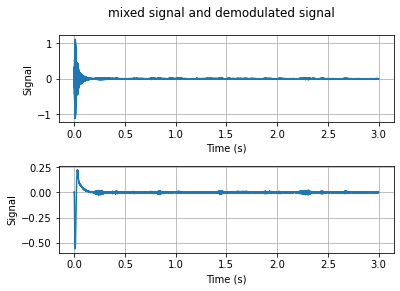

/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/3926485043.py:144: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_c=np.roll(X,np.int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
/var/folders/gj/ldtwgg_n0dngq84rgd6dmrdc0000gn/T/ipykernel_2829/619868501.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` t

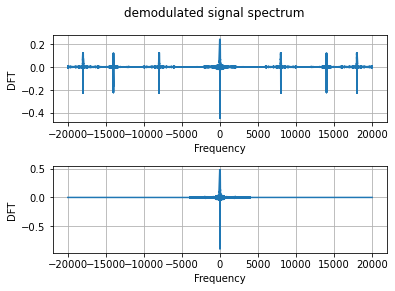

/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


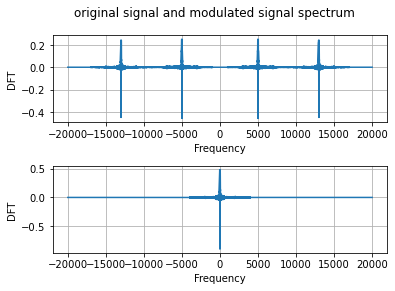

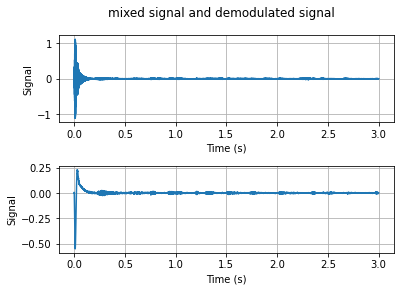

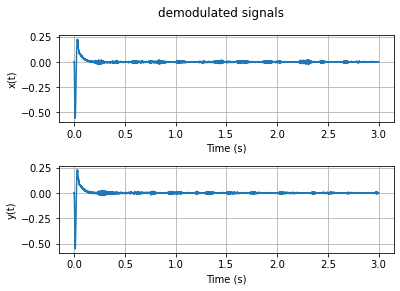

In [21]:
if __name__ == '__main__':
    
    # sigmalist = [1, 2, 4]
    # duration_of_signal = 50
    # sampling_frequency = 10
    # q_11(0, sigmalist, duration_of_signal, sampling_frequency)
    
    fs = 40000
    T = 3
    fmax = 4000
    g1 = 5000
    g2 = 13000
    
    myvoice = recordsound(T, fs)      
    x1 = myvoice.solve().reshape(T * fs)
    
    myvoice = recordsound(T, fs)      
    x2 = myvoice.solve().reshape(T * fs)
    # fs, x = read("myvoice.wav")

    # N = len(x)
    # print(N)
    # x_band, Treal, X_c, f_c, X_band = bandlimit(x, fs, fmax)
    # q_21(x, x_band, Treal, X_c, f_c, X_band)
    
    # # x_mod = cos_modu(x_band, g1, fs)
    # x_mod = q_22(x_band, g1, fs)
    # q_23(x_band, x_mod, fs, Treal)
    
    
    # fs, x1 = read("myvoice1.wav")
    x_band1, Treal, X_c, f_c, X_band = bandlimit(x1, fs, fmax)
    x_mod1 = cos_modu(x_band1, g1, fs)
    q_23(x_band1, x_mod1, fs, Treal)

    # fs, x2 = read("myvoice.wav")
    x_band2, Treal,X_c, f_c, X_band = bandlimit(x2, fs, fmax)
    x_mod2 = cos_modu(x_band2, g2, fs)
    q_23(x_band2, x_mod2, fs, Treal)
    
    z = x_mod1 + x_mod2
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('two original signals' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(Treal, x1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('x(t)')
    axs[1].plot(Treal, x2)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('y(t)')
    plt.show() 
    
    x_recons1 = q_25(z, g1, fs, fmax)
    x_recons2 = q_25(z, g2, fs, fmax)
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('demodulated signals' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(Treal, x_recons1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('x(t)')
    axs[1].plot(Treal, x_recons2)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('y(t)')
    plt.show() 

In [ ]:
def bandlimit(x, fs, fmax):
      
    N = len(x)
    DFT = dft(x, fs)
    [freqs, X, f_c, X_c] = DFT.first()
    
    index_max = np.max( np.where(f_c <= fmax)[0])
    index_min = np.min( np.where(f_c >= -fmax)[0])

    X_band = np.concatenate(( np.zeros(index_min+1), X_c[index_min: index_max] ,  np.zeros( N - index_max-1)))

    X_band_n = np.roll( X_band, np.int(np.ceil( N / 2 )))
      
    iDFT = idft(X_band_n, fs, N)
    x_bandlim, Treal = iDFT.solve_ifft()
    
    return x_bandlim.real, Treal,  X_c, f_c, X_band